<a href="https://colab.research.google.com/github/ojusgoel/Deepfake_FaceDetection_CNN/blob/main/DeepFake_FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import cv2
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:36<00:00, 223MB/s]
100% 3.75G/3.75G [00:36<00:00, 110MB/s]


In [4]:
%%capture
!unzip 140k-real-and-fake-faces.zip
!rm -rf 140k-real-and-fake-faces.zip

In [5]:
DATASET_PATH = "/content/real_vs_fake/real-vs-fake/train"
VAL_DATASET_PATH = "/content/real_vs_fake/real-vs-fake/valid"

REAL_PATH = os.path.join(DATASET_PATH, "real")
FAKE_PATH = os.path.join(DATASET_PATH, "fake")
IMG_SIZE = 224

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
import os

train_transforms = A.Compose([
    A.Resize(height=224, width=224),  # Ensure correct input size
    A.Rotate(limit=20),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=224, width=224),  # Ensure correct input size
    ToTensorV2()
])


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = self.transform(image=image)["image"]
        augmented = augmented.permute(1, 2, 0).numpy().astype(np.float32) / 255.0  # Ensure NumPy array
        # augmented = augmented.numpy().astype(np.float32) / 255.0  # Ensure NumPy array

        return augmented, label

# Define dataset paths
train_dir = "/content/real_vs_fake/real-vs-fake/train"
val_dir = "/content/real_vs_fake/real-vs-fake/valid"

# Load datasets
train_dataset = CustomDataset(train_dir, transform=train_transforms)
val_dataset = CustomDataset(val_dir, transform=val_transforms)

# Create DataLoaders
train_generator = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = DataLoader(val_dataset, batch_size=32, shuffle=False)


TypeError: Invalid shape (224, 3, 224) for image data

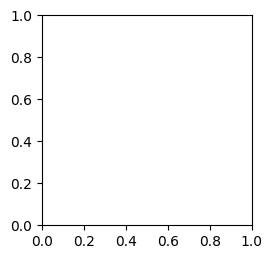

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create an iterator from the DataLoader
data_iter = iter(train_generator)

# Get a batch of images and labels
images, labels = next(data_iter)

# Convert tensors to NumPy arrays for visualization
images = images.permute(0, 2, 3, 1).cpu().numpy()  # Change shape from (B, C, H, W) -> (B, H, W, C)
labels = labels.cpu().numpy()

# Define function to display images
def plot_images(images, labels, num=6):
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, num//2, i+1)
        plt.imshow(images[i])
        plt.title("Fake" if labels[i] == 1 else "Real")
        plt.axis("off")
    plt.show()

# Display sample images
plot_images(images, labels)

# Architecure 2 in pytorch

In [16]:
# Earlier the code is in tensorflow, and now we are doing preprocessing in pytorch, so we need to convert pytorch processed to tensorflow.

# Now to make work easier, i am converting the model to pytorch

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the CNN Model in PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(256)
        self.bn9 = nn.BatchNorm2d(512)
        self.bn10 = nn.BatchNorm2d(512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.bn_fc2 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 7 * 7, 512)  # Adjust based on feature map size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = x.contiguous().view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.fc3(x))  # Binary classification output
        return x

In [10]:
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move to device
model = CNNModel().to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for images, labels in train_generator:
    images = images.permute(0, 3, 1, 2)  # Convert (batch, height, width, channels) -> (batch, channels, height, width)
    images, labels = images.to(device), labels.float().to(device)

    optimizer.zero_grad()
    outputs = model(images).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [34]:
import matplotlib.pyplot as plt

num_epochs = 20  # Adjust as needed
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_generator:
        images = images.permute(0, 3, 1, 2).to(device)  # Convert to (batch, C, H, W)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Binary classification threshold
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_generator)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Loop
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_generator:
            images = images.permute(0, 3, 1, 2).to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_generator)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch [1/20], Train Loss: 0.3446, Train Acc: 84.89%, Val Loss: 0.2153, Val Acc: 91.58%
Epoch [2/20], Train Loss: 0.2698, Train Acc: 88.74%, Val Loss: 0.1618, Val Acc: 93.41%
Epoch [3/20], Train Loss: 0.2197, Train Acc: 91.06%, Val Loss: 0.1183, Val Acc: 95.44%
Epoch [4/20], Train Loss: 0.1787, Train Acc: 92.90%, Val Loss: 0.0947, Val Acc: 96.39%
Epoch [5/20], Train Loss: 0.1529, Train Acc: 94.06%, Val Loss: 0.0791, Val Acc: 97.00%
Epoch [6/20], Train Loss: 0.1326, Train Acc: 94.89%, Val Loss: 0.0632, Val Acc: 97.67%


KeyboardInterrupt: 

NameError: name 'history' is not defined

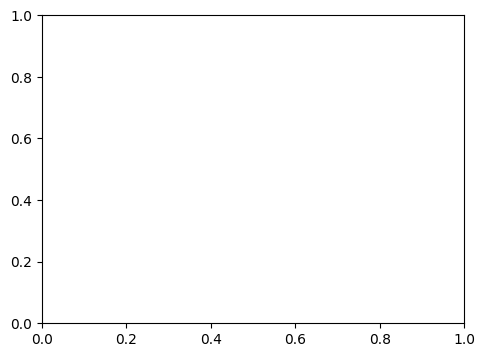

In [26]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")

plt.show()

In [35]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
# To be used when we need our trained model

model = MyModel()  # Replace with your model class
model.load_state_dict(torch.load("model_weights.pth"))
model.to(device)  # Move to GPU if needed
model.eval()  # Set to evaluation mode

In [36]:
# Define dataset paths
test_dir = "/content/real_vs_fake/real-vs-fake/test"

# Load datasets
test_dataset = CustomDataset(test_dir, transform=train_transforms)

# Create DataLoaders
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [37]:
import torch

# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.BCELoss()  # Assuming binary classification with sigmoid output

with torch.no_grad():  # No need to compute gradients during testing
    for images, labels in test_generator:  # Loop through test dataset

        images = images.permute(0, 3, 1, 2)  # Convert (batch, H, W, C) → (batch, C, H, W)
        images, labels = images.to(device), labels.float().to(device)  # Move data to GPU if available

        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total labels

# Compute final test loss and accuracy
test_loss /= len(test_generator)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0939
Test Accuracy: 96.18%


In [ ]:
# This was the previous code, our accuracy improved on data preprocessing

# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_acc:.4f}")
# print(f"Test Loss: {test_loss:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8575 - loss: 0.3082
Test Accuracy: 0.7973
Test Loss: 0.4571


In [32]:
plt.plot(history.history.get('acc', history.history.get('accuracy')), label='Train Accuracy')
plt.plot(history.history.get('val_acc', history.history.get('val_accuracy')), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [33]:
for key, value in history.history.items():
    print(f"{key}: {value[:5]}")  # Print first 5 values for each metric

NameError: name 'history' is not defined